In [ ]:
import pandas as pd
df = pd.read_csv('forestfires.csv')

In [ ]:
df.drop(['X','Y','month','day'], axis=1, inplace=True)
print(df.columns)

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'], dtype='object')


In [ ]:
df["FFMC"] = df["FFMC"].astype('category').cat.codes
df["DMC"] = df["DMC"].astype('category').cat.codes
df["DC"] = df["DC"].astype('category').cat.codes
df["ISI"] = df["ISI"].astype('category').cat.codes
df["temp"] = df["temp"].astype('category').cat.codes
df["RH"] = df["RH"].astype('category').cat.codes
df["wind"] = df["wind"].astype('category').cat.codes
df["rain"] = df["rain"].astype('category').cat.codes
df["area"] = df["area"].astype('category').cat.codes

df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,28,37,41,29,12,34,14,0,0
1,56,49,144,42,85,16,1,0,0
2,56,56,156,42,55,16,2,0,0
3,67,48,33,64,13,72,8,1,0
4,46,66,46,68,30,73,3,0,0


In [ ]:
df.tail()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
512,9,71,141,7,172,15,5,0,123
513,9,71,141,7,123,54,12,0,228
514,9,71,141,7,116,53,14,0,167
515,92,168,122,80,156,25,8,0,0
516,7,2,48,4,34,14,9,0,0


In [ ]:
from sklearn.preprocessing import PowerTransformer

df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

print(df)

         FFMC       DMC        DC       ISI      temp        RH      wind  \
0   -1.531865 -1.478905 -1.428986 -1.081330 -1.851859  0.566736  1.405438   
1   -0.428556 -1.262787  0.282685 -0.576673 -0.194958 -0.622917 -2.251716   
2   -0.428556 -1.137107  0.489685 -0.576673 -0.841947 -0.622917 -1.771052   
3    0.075826 -1.280763 -1.554219  0.215945 -1.826117  2.180229  0.120335   
4   -0.854962 -0.957974 -1.349835  0.354009 -1.410602  2.214713 -1.368228   
..        ...       ...       ...       ...       ...       ...       ...   
512 -2.076760 -0.868569  0.231120 -2.062025  1.566811 -0.708245 -0.696554   
513 -2.076760 -0.868569  0.231120 -2.062025  0.590729  1.502996  1.012938   
514 -2.076760 -0.868569  0.231120 -2.062025  0.448207  1.461655  1.405438   
515  1.341700  0.851856 -0.093620  0.759433  1.251824  0.035815  0.120335   
516 -2.119441 -2.118443 -1.318005 -2.224230 -1.317035 -0.796872  0.360101   

         rain      area  
0   -0.125368 -1.008180  
1   -0.125368 -1.008180

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [ ]:
data_cols = df.columns

In [ ]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

9


In [ ]:
!mkdir model

In [ ]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

Streaming output truncated to the last 5000 lines.
51 [D loss: 0.512234, acc.: 67.19%] [G loss: 1.082417]
52 [D loss: 0.404852, acc.: 87.50%] [G loss: 1.363082]
53 [D loss: 0.323977, acc.: 93.75%] [G loss: 1.530766]
54 [D loss: 0.314173, acc.: 93.75%] [G loss: 1.549205]
55 [D loss: 0.282004, acc.: 98.44%] [G loss: 1.541224]
56 [D loss: 0.283021, acc.: 96.88%] [G loss: 1.515826]
57 [D loss: 0.265327, acc.: 98.44%] [G loss: 1.466337]
58 [D loss: 0.278944, acc.: 96.88%] [G loss: 1.358998]
59 [D loss: 0.285309, acc.: 96.88%] [G loss: 1.431331]
60 [D loss: 0.295992, acc.: 96.88%] [G loss: 1.373145]
61 [D loss: 0.298203, acc.: 96.88%] [G loss: 1.276389]
62 [D loss: 0.348637, acc.: 89.06%] [G loss: 1.282196]
63 [D loss: 0.336426, acc.: 93.75%] [G loss: 1.383963]
64 [D loss: 0.343207, acc.: 93.75%] [G loss: 1.385822]
65 [D loss: 0.361425, acc.: 89.06%] [G loss: 1.652124]
66 [D loss: 0.315210, acc.: 87.50%] [G loss: 1.756417]
67 [D loss: 0.336840, acc.: 87.50%] [G loss: 1.986834]
68 [D loss: 0.

In [ ]:
!mkdir model/gan
!mkdir model/gan/saved

In [ ]:
synthesizer.save('model/gan/saved', 'generator_forestfire')

In [ ]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 32)]                0         
                                                                 
 dense (Dense)               (32, 128)                 4224      
                                                                 
 dense_1 (Dense)             (32, 256)                 33024     
                                                                 
 dense_2 (Dense)             (32, 512)                 131584    
                                                                 
 dense_3 (Dense)             (32, 9)                   4617      
                                                                 
Total params: 173,449
Trainable params: 173,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 9)]                 0         
                                                                 
 dense_4 (Dense)             (32, 512)                 5120      
                                                                 
 dropout (Dropout)           (32, 512)                 0         
                                                                 
 dense_5 (Dense)             (32, 256)                 131328    
                                                                 
 dropout_1 (Dropout)         (32, 256)                 0         
                                                                 
 dense_6 (Dense)             (32, 128)                 32896     
                                                                 
 dense_7 (Dense)             (32, 1)                   129 

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

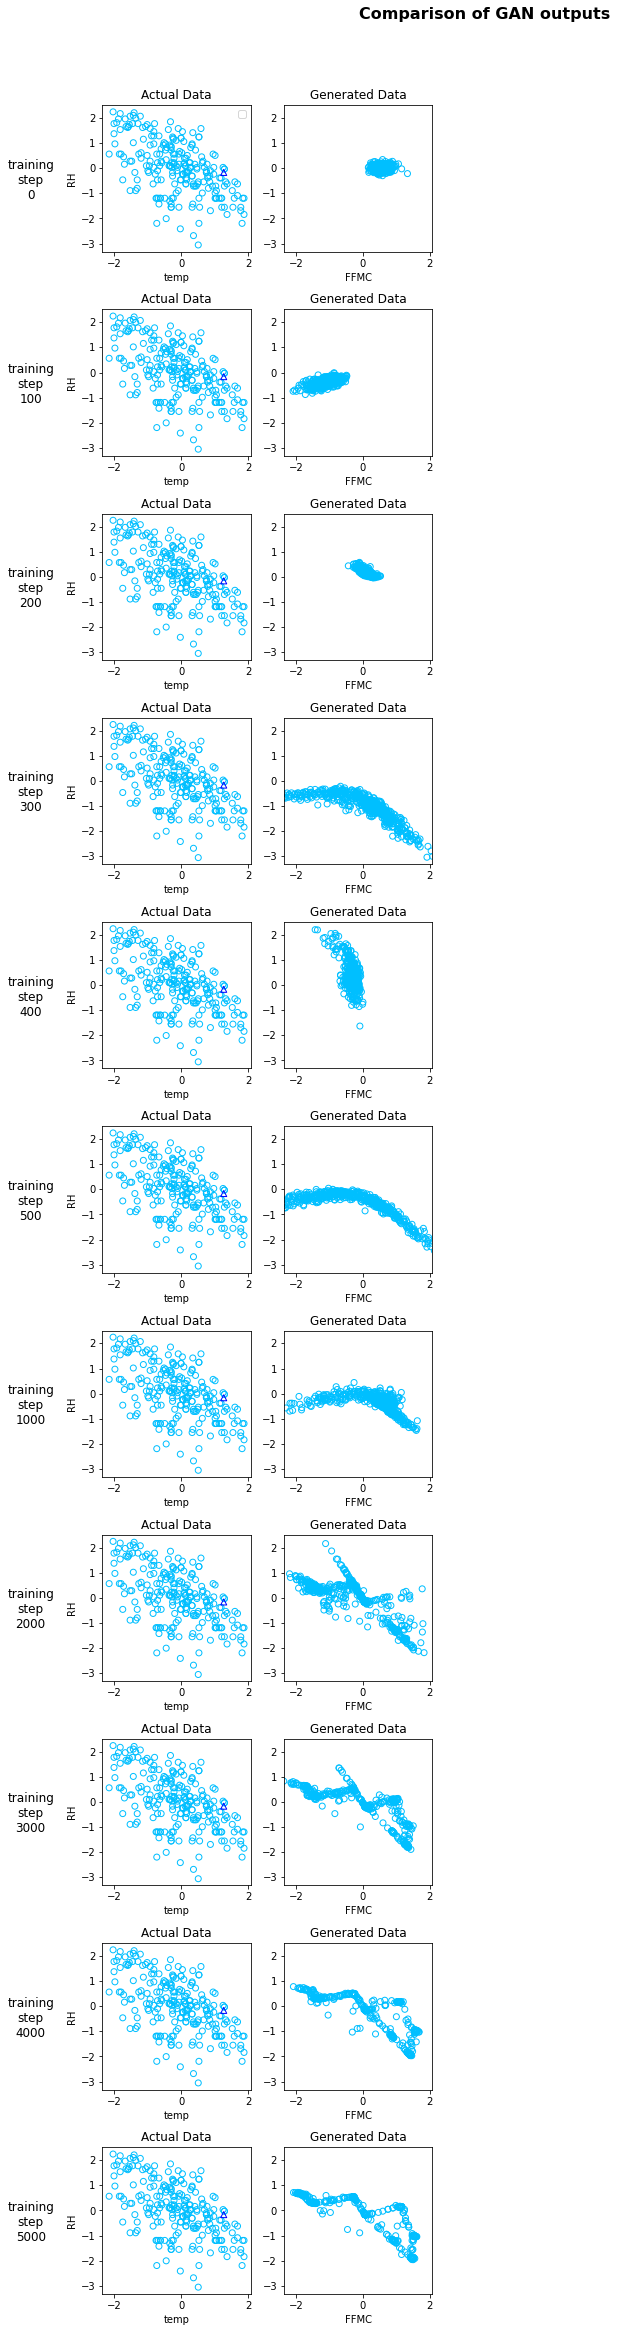

In [ ]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'temp', 'RH'

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('area'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

In [ ]:
!pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 9.6 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [ ]:
gen_df = pd.read_csv('Generated_sample.csv')

In [ ]:
gen_df.drop('Unnamed: 0', axis=1, inplace=True)
print(gen_df.columns)
print(df.shape, gen_df.shape)

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'], dtype='object')
(517, 9) (492, 9)


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


517 492


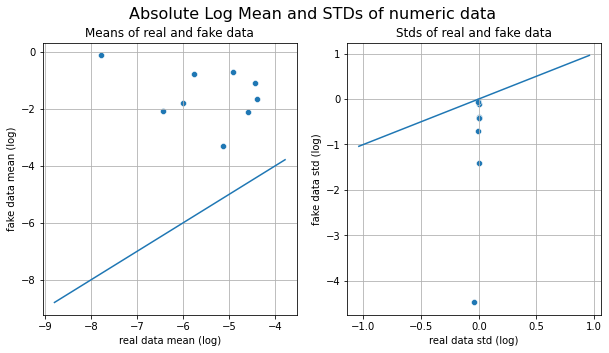

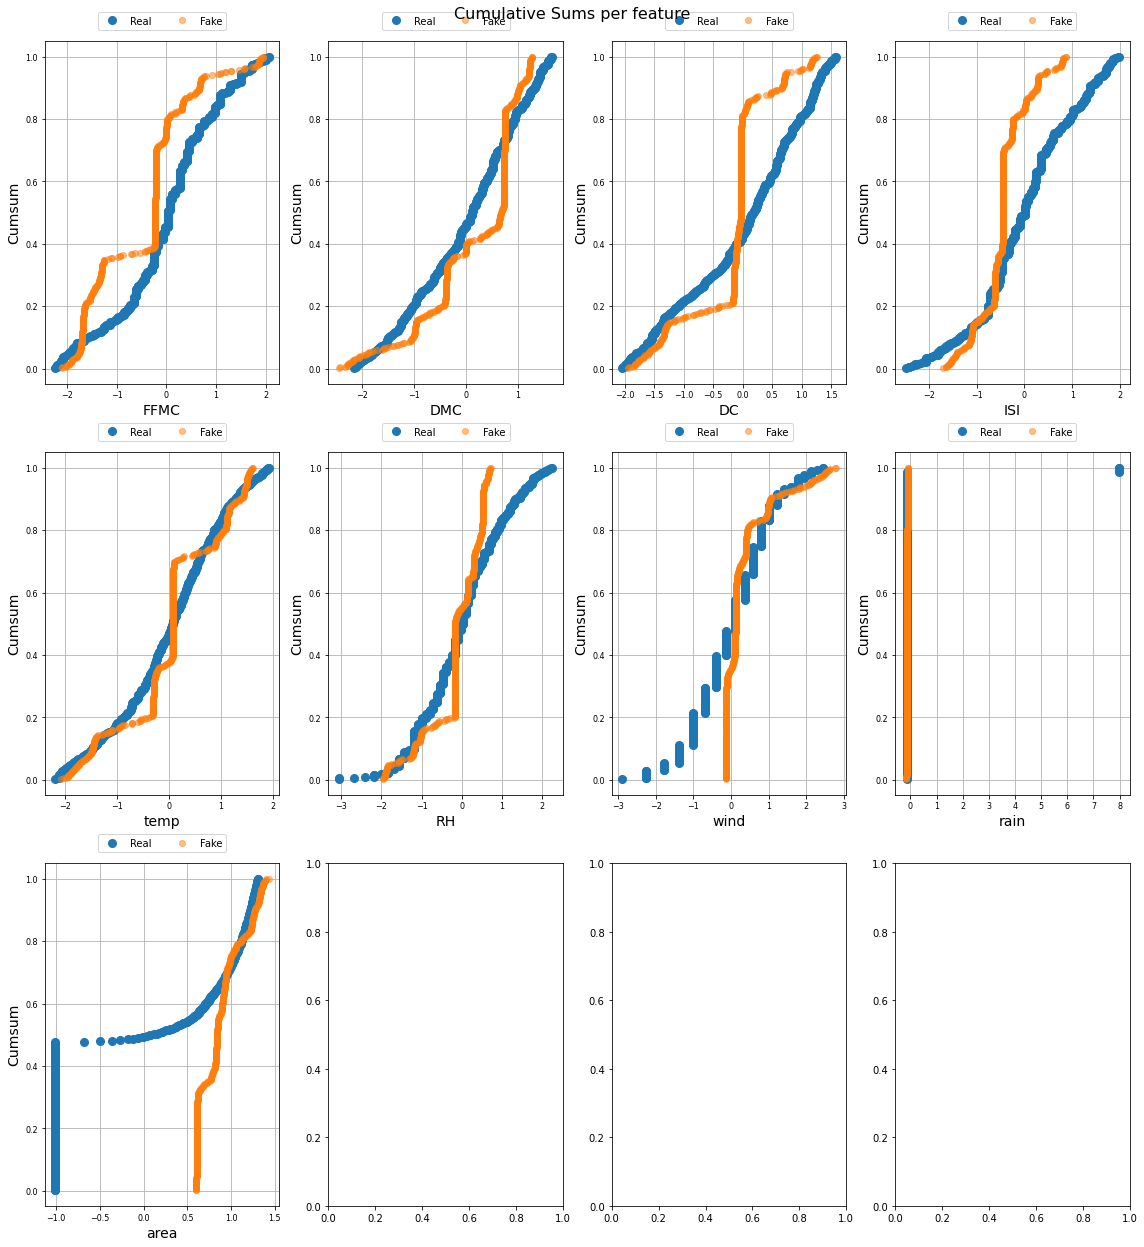

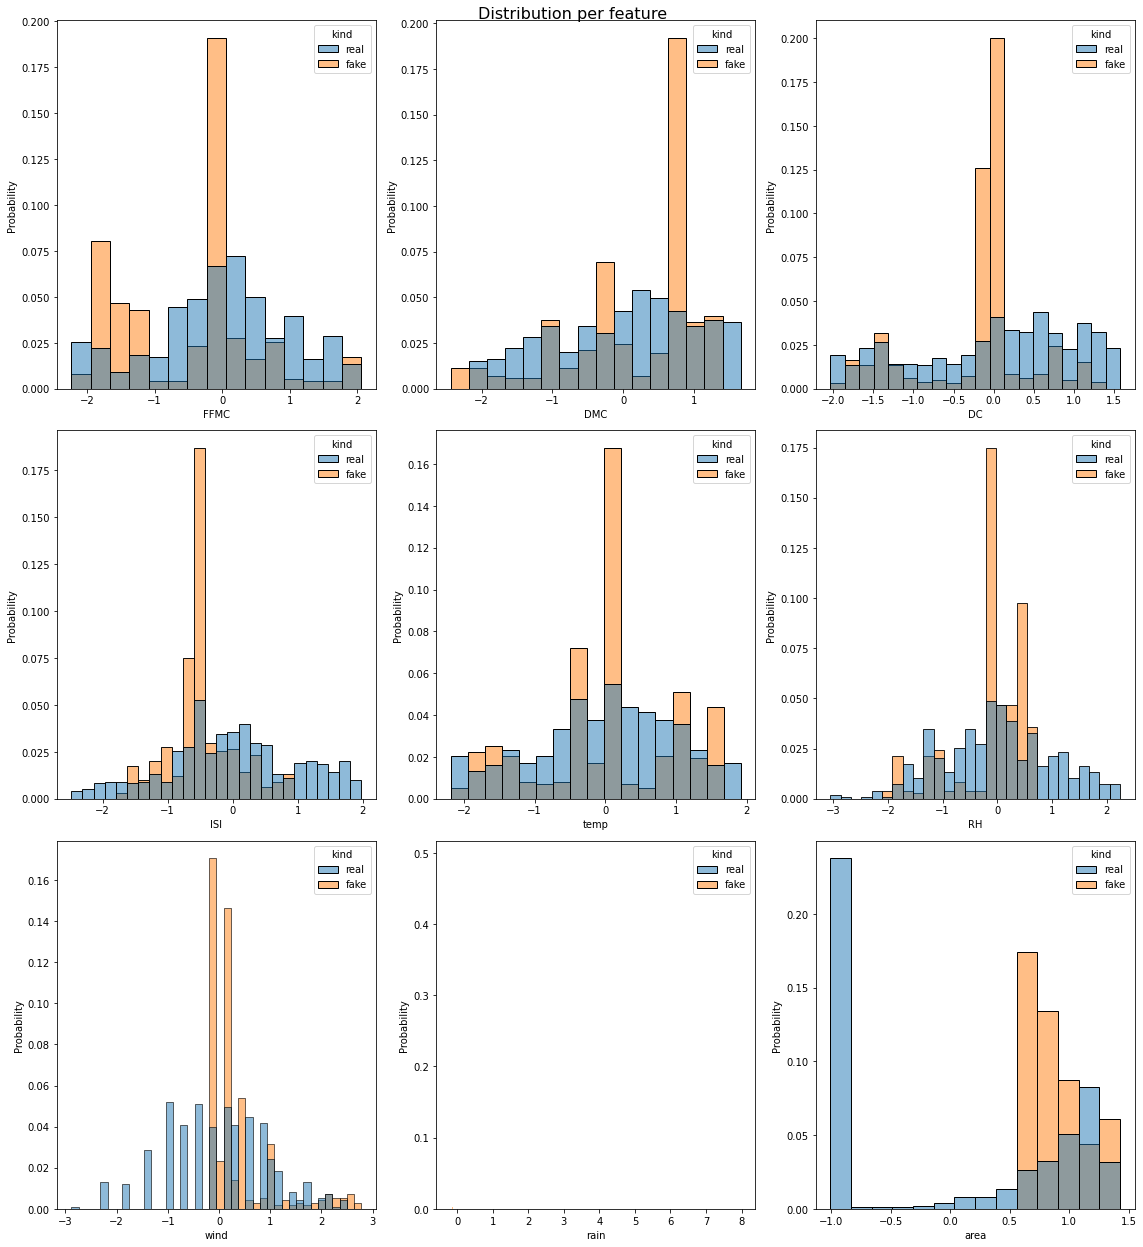

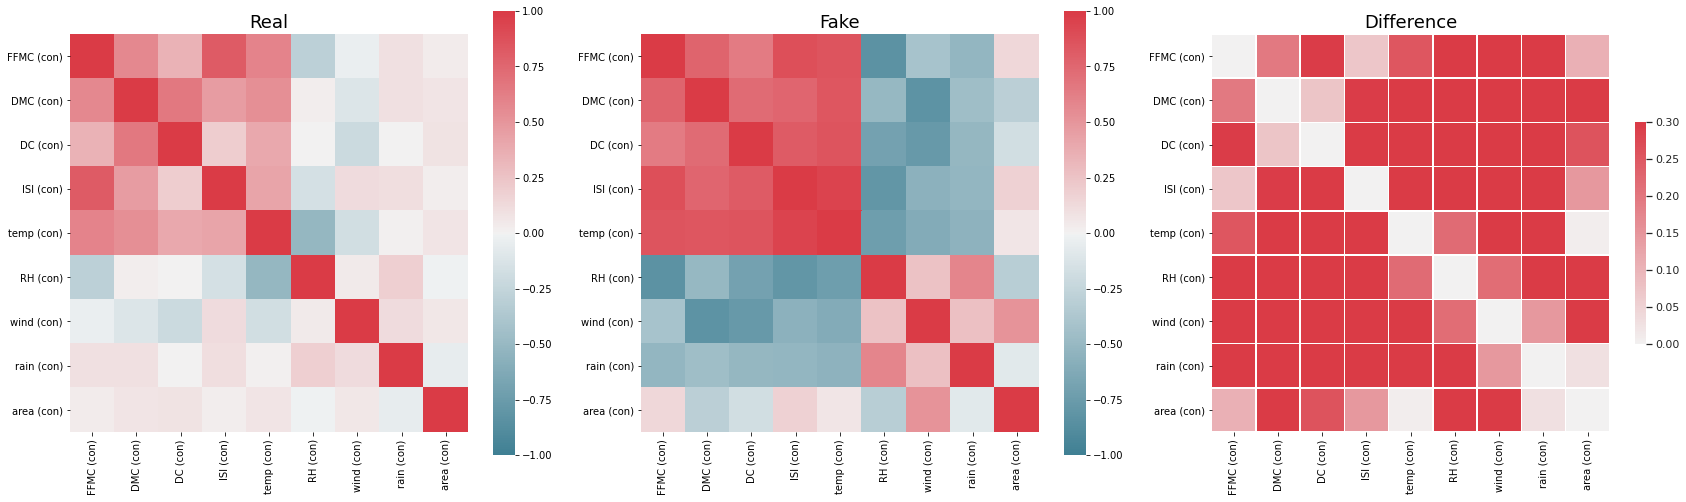

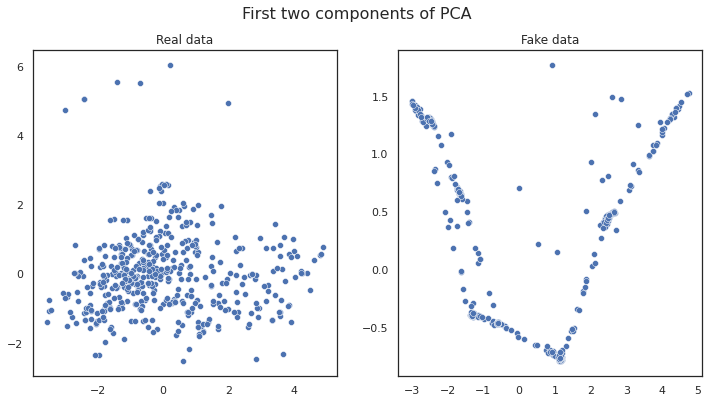

In [ ]:
from table_evaluator import load_data, TableEvaluator

cat_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

print(len(df), len(gen_df))
table_evaluator =  TableEvaluator(df, gen_df)

table_evaluator.visual_evaluation()